<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [56]</a>'.</span>

# TC.L.ITF.1.2.3.3 Science Data Stream Integration (including TMC)
|||
|---|---|
|**Test ID:** |TBA|
|**Test Plan:**|TBA|
|**Test Cycle:**|TBA|
|**Jama Test Case Link:**| https://skaoffice.jamacloud.com/perspective.req#/testCases/1121474?projectId=335 |


## Author: Alex Hill

This notebook demonstrates the integration between between SPS, CSP and SDP, orchestrated via TMC.

**TODO: rewrite below**

  In this specific test case, we use the CNIC VD to simulate 6 station beams as an input to CSP. Each of these station beams received the same random noise signal, but it's source strength scales with station ID. In the CNIC configuration cell, the strength of the signal is $1000s$, where $s$ is the station ID. 

These virtual signals are then passed into the P4 switch. Based on our specified routing unicast SPEAD rules, these packets will flow to a correlator. The subsequent correlated data will be routed to SDP based on the IP and MAC addresses we specify to the P4.

These packets will be received and processed by SDP before being written as a Measurement Set (MS) file at the conclusion of the scan.

This MS will then be analysed in the notebook by generating a correlation matrix for the stations. 

This process will then be repeated but the output for the correlated data will be sent to a sink CNIC instead of SDP. There we will capture the raw SPEAD data and generate another correlation matrix. These two correlation matrices will be compared for equality to ensure integration.

<div>
    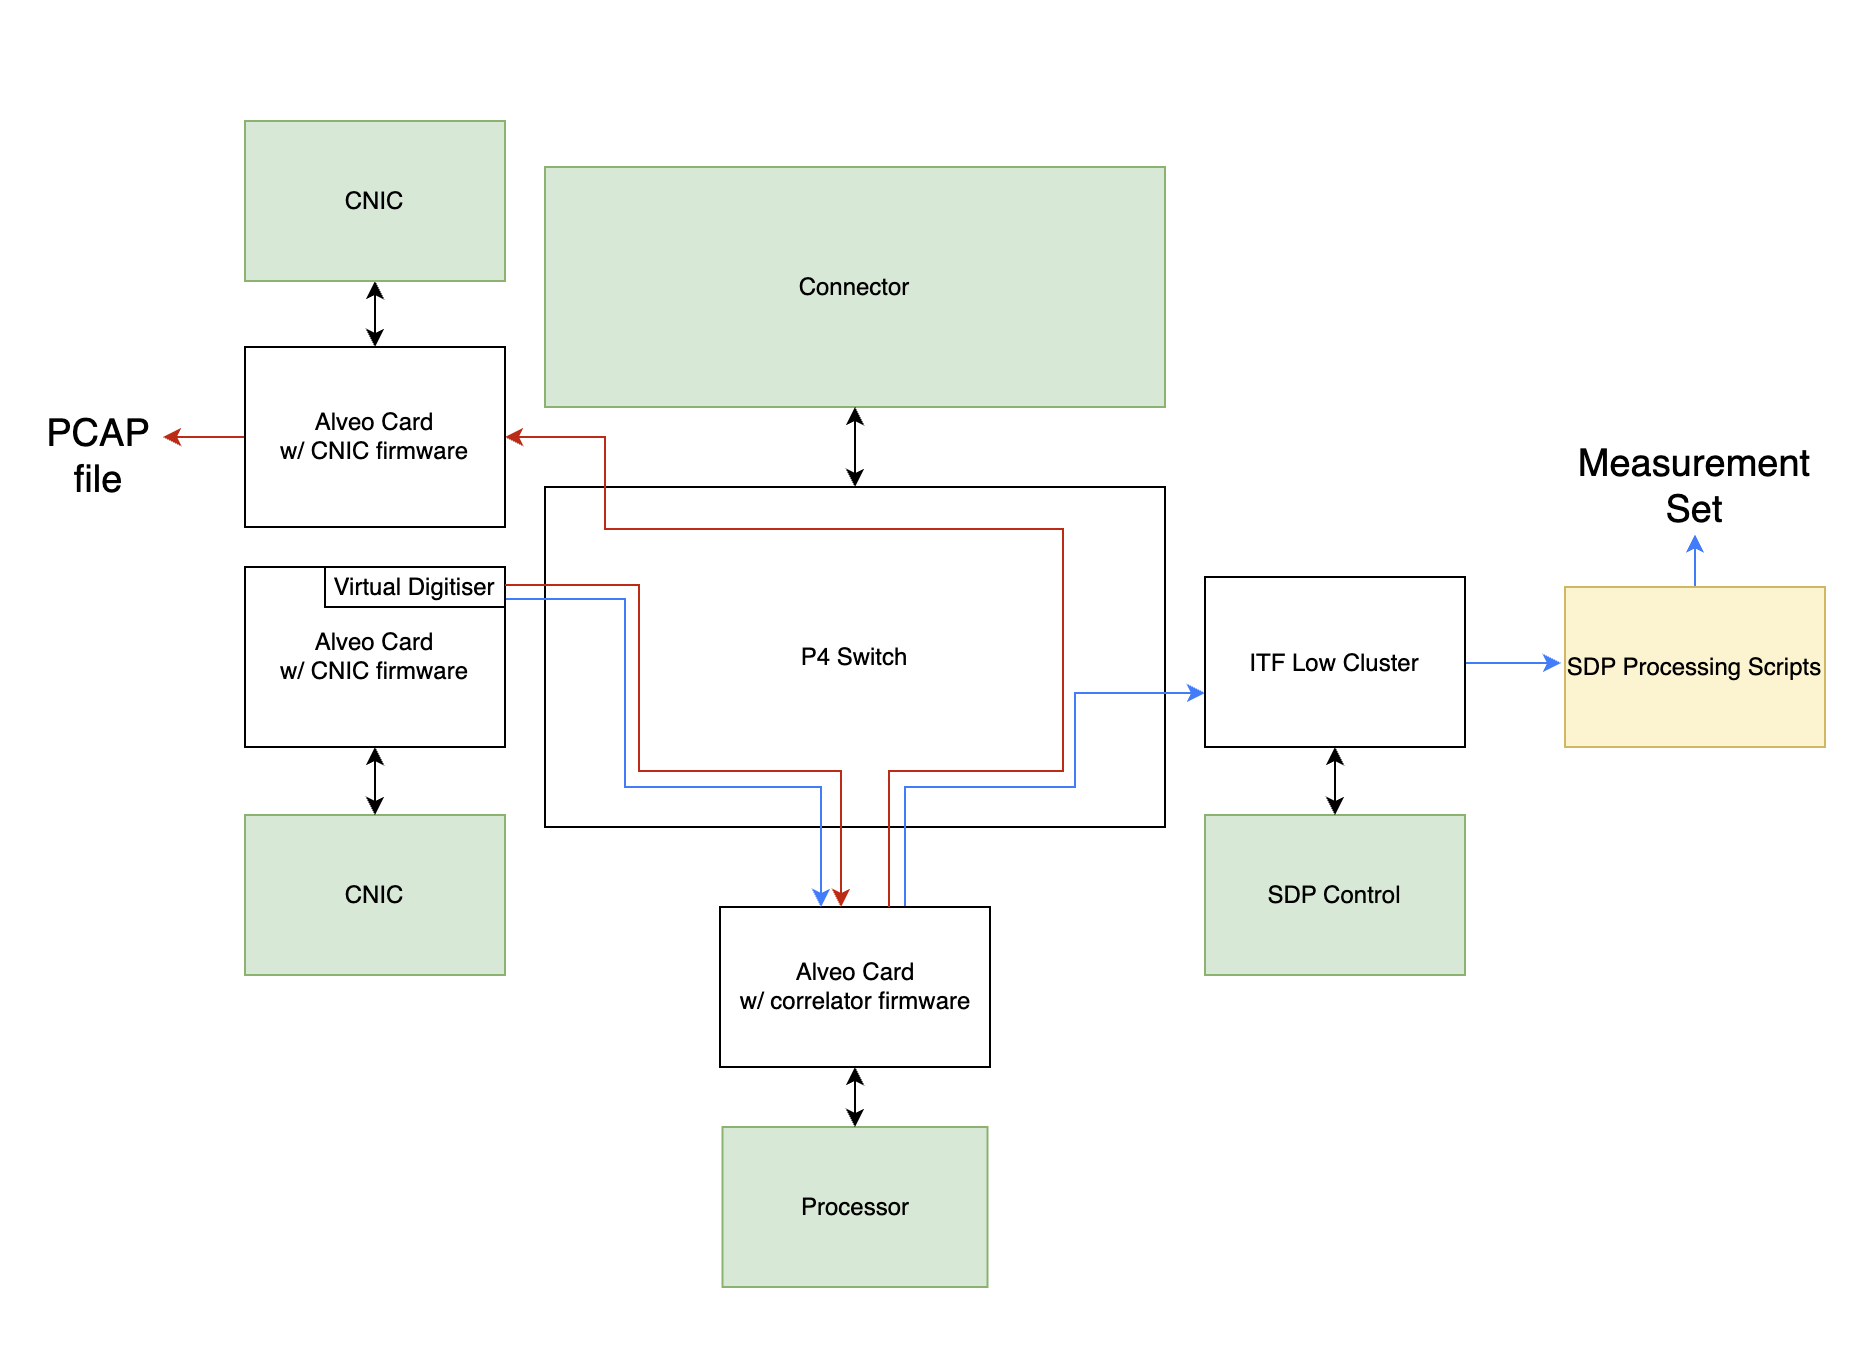
</div>    

## Initial Setup

#### Parameters ( If notebook invoked by Papermill)

In [1]:
max_init_attempts = 5
spsstation_init_retries = 1
run_name = None
run_dir = None

In [2]:
# Parameters
run_dir = "."
run_name = "testrun03"

In [3]:
!pip install humanize

In [4]:
import json
import logging
import os
import random
import sys
from datetime import date
from pathlib import Path

import papermill
from papermill import PapermillExecutionError
import ska_sdp_config
import ska_ser_logging
from tango import DevFailed, DeviceProxy, DevSource, EventType

logger = logging.getLogger(__name__)
ska_ser_logging.configure_logging(level=logging.INFO)

In [5]:
from aiv_utils.fault_simulation import trigger_fault_sdp

In [6]:
# TMC, control and subarray devices
tm_central = DeviceProxy("ska_low/tm_central/central_node")
tm_subarray = DeviceProxy("ska_low/tm_subarray_node/1")

tm_subarray.set_timeout_millis(10000)

mccs_subarray = DeviceProxy(tm_subarray.mccsSubarrayDevName)
csp_subarray = DeviceProxy(tm_subarray.cspSubarrayDevName)
sdp_subarray = DeviceProxy(tm_subarray.sdpSubarrayDevName)

mccs_control = DeviceProxy(tm_central.mccsMasterName)
csp_control = DeviceProxy(tm_central.cspMasterDevName)
sdp_control = DeviceProxy(tm_central.sdpMasterDevName)

# CBF-specific devices
cbf_subarray = DeviceProxy("low-cbf/subarray/01")
allocator = DeviceProxy("low-cbf/allocator/0")
cnic = DeviceProxy("low-cbf/cnic/2")
connector = DeviceProxy("low-cbf/connector/0")

In [7]:
### Calibrate the Stations

In [8]:
def get_sut_device(fqdn):
    device = DeviceProxy(f"tango-databaseds.sut-mccs:10000/{fqdn}")
    # ensure we don't get cached data
    device.set_source(DevSource.DEV)
    return device

In [9]:
def get_tiles(station):
    tile_fqdns = station.get_property("TileFQDNS")["TileFQDNS"]
    return [get_sut_device(fqdn) for fqdn in tile_fqdns]

In [10]:
def get_station(station_name: str):
    # station = DeviceProxy(f"low-mccs/spsstation/{station_name}")
    station = DeviceProxy(
        f"tango-databaseds.sut-mccs:10000/low-mccs/spsstation/{station_name}"
    )
    # operations over 16 TPMs have a tendency to exceed the default 3000ms timeout
    station.set_timeout_millis(10000)
    station.set_source(DevSource.DEV)
    return station

In [11]:
def setup_station_calibration(
    station, antennas_in_beam, gain=1.0, delay_after_stopping=2
):
    print(f"setting up calibration for {station.name()}")
    print("stopping station beamformer ..")
    station.stopbeamformer()
    import time

    time.sleep(delay_after_stopping)
    num_antennas_in_station = 32
    bank = 0

    for tile in get_tiles(station):
        antenna_ids = [bank + i for i in range(16)]
        tile.antennaids = antenna_ids
        bank += 16

    # represent 2x2 complex matrix as a flattened list of floats
    # i.e.
    #  re1 + i*im1, re2 + i*im2
    #  re3+i*im3,   re4 + i*im4
    # is represented as:
    # 8 floats :   [re1,im1,re2,im2,re3,im3,re4,im4]

    in_beam_matrix = [
        gain,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        gain,
        0.0,
    ]  # 2x2 scaled / gained complex identity matrix
    num_complex_components = 4  # 2x2 complex "Jones Matrix"
    num_real_components = 2 * num_complex_components
    out_of_beam_matrix = [0.0] * num_real_components
    num_channels = 384

    for antenna_id in range(num_antennas_in_station):
        if antenna_id in antennas_in_beam:
            # NB antenna id is prepended
            print(f"{antenna_id} in beam 0 - loading in beam matrix {in_beam_matrix}")
            station.LoadCalibrationCoefficients(
                [antenna_id] + in_beam_matrix * num_channels
            )
        else:
            print(
                f"{antenna_id} out of beam 0 - loading out of beam matrix {out_of_beam_matrix}"
            )
            station.LoadCalibrationCoefficients(
                [antenna_id] + out_of_beam_matrix * num_channels
            )

    time.sleep(3)
    print(f"applying calibration {station.name()}")
    station.applycalibration("")

In [12]:
def get_stations():
    return [get_station(station_name) for station_name in ["itf1", "itf2"]]

In [13]:
GAIN = 4
ANTENNAS_IN_BEAM = [8, 24]

for station in get_stations():
    setup_station_calibration(station, ANTENNAS_IN_BEAM, gain=GAIN)

setting up calibration for low-mccs/spsstation/itf1
stopping station beamformer ..


0 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
3 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
4 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
5 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
6 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
7 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
8 in beam 0 - loading in beam matrix [4, 0.0, 0.0, 0.0, 0.0, 0.0, 4, 0.0]
9 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
10 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
11 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0

applying calibration low-mccs/spsstation/itf1
setting up calibration for low-mccs/spsstation/itf2
stopping station beamformer ..


0 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
3 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
4 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
5 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
6 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
7 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
8 in beam 0 - loading in beam matrix [4, 0.0, 0.0, 0.0, 0.0, 0.0, 4, 0.0]
9 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
10 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
11 out of beam 0 - loading out of beam matrix [0.0, 0.0, 0.0, 0.0

applying calibration low-mccs/spsstation/itf2


### Analog Chain

In [14]:
# from datetime import datetime
# analog_execution = papermill.execute_notebook(
#     "analog_chain.ipynb",
#     f"analog_chain_{datetime.now()}.ipynb",
#     cwd=".",
#     stdout_file=sys.stdout,
#     stderr_file=sys.stderr,
#     parameters={"param_command": "start"}
# )

### Define some helper functions

In [15]:
# Helper functions
import time

TIMEOUT = 60.0
INTERVAL = 0.5


def wait_for_state(device, state, timeout=TIMEOUT):
    """
    Wait for device state to have the expected value.

    :param device: device client
    :param state: the expected state
    :param timeout: timeout in seconds
    """

    def predicate():
        return device.state() == state

    description = f"Device state {state.name}"
    logger.info(f"Waiting for device state {state.name}...")
    wait_for_predicate(predicate, description, timeout=timeout)


def wait_for_predicate(predicate, description, timeout=TIMEOUT, interval=INTERVAL):
    """
    Wait for predicate to be true.

    :param predicate: callable to test
    :param description: description to use if test fails
    :param timeout: timeout in seconds
    :param interval: interval between tests of the predicate in seconds

    """
    start = time.time()
    while True:
        if predicate():
            break
        if time.time() >= start + timeout:
            raise TimeoutError(f"{description} not achieved after {timeout} seconds")
        time.sleep(interval)


def wait_for_obs_state(device, obs_state, timeout=TIMEOUT):
    """
    Wait for obsState to have the expected value.

    :param device: device proxy
    :param obs_state: the expected value
    :param timeout: timeout in seconds
    """

    def predicate():
        return device.obsState == obs_state

    description = f"obsState {obs_state.name}"
    logger.info(f"Waiting for device obs_state {obs_state.name}...")
    wait_for_predicate(predicate, description, timeout=timeout)
    logger.info(f"Device obs_state {obs_state.name} has been reached")


def subarray_safe_release(device):
    """
    Safely releases subarray tango device to EMPTY obsState
    """
    if device.obsState == device.obsState.SCANNING:
        logger.info(">> End Scan")
        device.EndScan()
        wait_for_obs_state(device, device.obsState.READY)

    if device.obsState == device.obsState.READY:
        logger.info(">> End")
        device.End()
        wait_for_obs_state(device, device.obsState.IDLE)

    try:
        if device.obsState == device.obsState.IDLE:
            logger.info(">> Releasing All Resources")
            device.ReleaseAllResources()
            wait_for_obs_state(device, device.obsState.EMPTY)
    except DevFailed:
        # Execution block in progress may occur if never configured
        if device.obsState == device.obsState.IDLE:
            logger.info(">> Configure")
            scan_type_ids = list(
                filter(
                    lambda v: v != "interface",
                    json.loads(device.receiveAddresses).keys(),
                )
            )
            device.Configure(
                json.dumps(
                    {
                        "interface": "https://schema.skao.int/ska-sdp-configure/0.4",
                        "scan_type": scan_type_ids[0],
                    }
                )
            )
            wait_for_obs_state(device, device.obsState.READY)
            device.End()
            wait_for_obs_state(device, device.obsState.IDLE)

    if device.obsState == device.obsState.IDLE:
        logger.info(">> Releasing All Resources")
        device.ReleaseAllResources()
        wait_for_obs_state(device, device.obsState.EMPTY)

    if device.obsState == device.obsState.FAULT:
        device.Restart()
        wait_for_obs_state(device, device.obsState.EMPTY)

    assert device.obsState == device.obsState.EMPTY
    logger.info("Tango Device is EMPTY")

### ***non-TMC***: create a destination IP/MAC in the connector

In [16]:
csp_ingest_ip = "10.135.180.109"
csp_mac = "aa:bb:cc:dd:ee:ff"
arp_table = json.loads(connector.arproutingtable)
if csp_ingest_ip not in [entry["IP"] for entry in arp_table["ARP"]]:
    connector.addarpentry(
        json.dumps(
            {
                "arp": [
                    {
                        "ip": {"address": csp_ingest_ip},
                        "mac": {"address": csp_mac},
                    }
                ]
            }
        )
    )
display(arp_table)

{'ARP': [{'IP': '10.135.180.109', 'Mac': 'aa:bb:cc:dd:ee:ff'}]}

### TODO: Check sdp-deployments namespace is empty (no lingering vis-receive pods)

## Observation parameters

In [17]:
num_stations = 2
station_ids = list(range(1, num_stations + 1))
band_channels = 64
# start_channel = 96
start_channel = 96
# coarse_channels = list(range(start_channel, start_channel + band_channels))

coarse_channels = [100, 101, 102, 103, 104, 105]


def visibility_frequency(first_freq_id: int, n_fine_ch: int, visibility: int) -> float:
    """
    Calculate a correlation visibility's centre frequency.

    :param first_freq_id: SPS Frequency ID (aka coarse channel)
    :param n_fine_ch: Number of fine channels integrated in our
      correlation.
    :param visibility: index number
    :return: Centre Frequency (Hz)
    """
    CORR_FINE_CH_HZ = (1 / 1080e-9) * (8 / 32768)  # 226.056 134 259 259...
    SPS_COARSE_SPACING_HZ = 781_250
    return (
        first_freq_id * SPS_COARSE_SPACING_HZ  # centre frequency
        # minus half of the total fine channels BW, gives centre of lowest fine ch.
        - (3456 / 2) * CORR_FINE_CH_HZ
        # minus half a fine channel, gives bottom frequency of our visibility
        - CORR_FINE_CH_HZ / 2
        # plus half a Correlation BW, gives centre freq. of first visibility
        + CORR_FINE_CH_HZ * n_fine_ch / 2
        # increment by one step for each visibility
        + visibility * (CORR_FINE_CH_HZ * n_fine_ch)
    )


freq_min = visibility_frequency(coarse_channels[0], 24, 0)
print(freq_min)
freq_max = visibility_frequency(coarse_channels[-1], 24, 143)
print(freq_max)

77736974.64554398
82419049.29832175


In [18]:
#
# "freq_min\": 77736974.64554398,\n",
# -    "                        \"freq_max\": 82419049.29832175,\n",

## Assign Resources

In [19]:
# Some vars for SDP
START_CHANNEL = 0
TOTAL_STREAMS = len(coarse_channels)  # total number of spead streams to use
TOTAL_CHANNELS = 144 * TOTAL_STREAMS  # should match emulator data

In [20]:
# VIS_RECEIVE_VERSION = "2.2.0"
VIS_RECEIVE_VERSION = "4.2.1"
"""
Creates a vis-receive assignres command to be executed on a new execution block. This
is to be compliant with SKA telmodel schema documented at:
https://developer.skao.int/projects/ska-telmodel/en/latest/schemas/ska-sdp-assignres.html
"""
generator = "notebook"
today = date.today().strftime("%Y%m%d")
number = random.randint(0, 99998)

EXECUTION_BLOCK_ID = f"eb-{generator}-{today}-{number:05d}"
PROCESSING_BLOCK_ID_REALTIME_RECEIVER = f"pb-{generator}-{today}-{number+1:05d}"

sdp_assign_resources = {
    "interface": "https://schema.skao.int/ska-sdp-assignres/0.4",
    "resources": {
        "csp_links": [1, 1],
        "receive_nodes": 1,
        "receptors": ["C1", "C2"],
    },
    "execution_block": {
        "eb_id": f"{EXECUTION_BLOCK_ID}",
        "max_length": 21600.0,
        "context": {},
        "scan_types": [
            {
                "scan_type_id": "target:a",
                "beams": {
                    "vis0": {
                        "field_id": "field_a",
                        "channels_id": "vis_channels",
                        "polarisations_id": "all",
                    }
                },
            },
        ],
        "beams": [
            {"beam_id": "vis0", "function": "visibilities"},
        ],
        "channels": [
            {
                "channels_id": "vis_channels",
                "spectral_windows": [
                    {
                        "spectral_window_id": "all_channels",
                        "count": TOTAL_CHANNELS,
                        "start": START_CHANNEL,
                        "stride": 1,
                        "freq_min": freq_min,
                        "freq_max": freq_max,
                        "link_map": [[0, 0], [200, 1], [744, 2], [944, 3]],
                    }
                ],
            }
        ],
        "polarisations": [
            {
                "polarisations_id": "all",
                "corr_type": ["XX", "XY", "YX", "YY"],
            }
        ],
        "fields": [
            {
                "field_id": "field_a",
                "phase_dir": {
                    "ra": [0.0],
                    "dec": [-26.74],
                    "reference_time": "...",
                    "reference_frame": "ICRF3",
                },
            },
        ],
    },
    "processing_blocks": [
        {
            "pb_id": f"{PROCESSING_BLOCK_ID_REALTIME_RECEIVER}",
            "script": {
                "kind": "realtime",
                "name": "vis-receive",
                "version": VIS_RECEIVE_VERSION,
            },
            "parameters": {
                "use_network_definition": True,
                "pod_settings": [{"securityContext": {"runAsUser": 0, "fsGroup": 0}}],
            },
        }
    ],
}

mccs_assign_resources = {
    "interface": "https://schema.skao.int/ska-low-mccs-controller-allocate/3.0",
    "subarray_beams": [
        {
            "subarray_beam_id": 1,
            "apertures": [
                {"station_id": 1, "aperture_id": "AP001.01"},
                {"station_id": 2, "aperture_id": "AP002.01"},
            ],
            "number_of_channels": band_channels,
        }
    ],
}


mccs_assign_resources_new = {
    "station_ids": [[1, 2]],
    "subarray_beam_ids": [1],
    "channel_blocks": [3],
}

In [21]:
LOW_TMC_ASSIGNRESOURCES_3_2 = {
    "interface": "https://schema.skao.int/ska-low-tmc-assignresources/3.2",
    "transaction_id": "txn-....-00001",  # TODO what's going on here?
    "subarray_id": 1,
    "mccs": mccs_assign_resources,
    "sdp": sdp_assign_resources,
}

tm_central.assignresources(json.dumps(LOW_TMC_ASSIGNRESOURCES_3_2))
wait_for_obs_state(tm_subarray, tm_subarray.obsState.IDLE, timeout=60)

1|2024-08-20T05:13:20.520Z|INFO|MainThread|wait_for_obs_state|128461363.py#57||Waiting for device obs_state IDLE...


1|2024-08-20T05:13:25.026Z|INFO|MainThread|wait_for_obs_state|128461363.py#59||Device obs_state IDLE has been reached


In [22]:
import pandas as pd

pd.DataFrame(
    [
        {
            "device": d.dev_name(),
            "state": d.State(),
            "obsState": str(d.obsState),
        }
        for d in [tm_subarray, mccs_subarray, csp_subarray, sdp_subarray]
    ]
)

1|2024-08-20T05:13:25.213Z|INFO|MainThread|_init_num_threads|utils.py#145||Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.


1|2024-08-20T05:13:25.214Z|INFO|MainThread|_init_num_threads|utils.py#148||Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


1|2024-08-20T05:13:25.215Z|INFO|MainThread|_init_num_threads|utils.py#160||NumExpr defaulting to 8 threads.


device  state obsState
0  ska_low/tm_subarray_node/1      0        2
1        low-mccs/subarray/01      0        2
2         low-csp/subarray/01      0        2
3         low-sdp/subarray/01      0        1

In [23]:
# tm_subarray.Abort()
# wait_for_obs_state(tm_subarray, tm_subarray.obsState.ABORTED, timeout=30)

In [24]:
# tm_subarray.Restart()
# wait_for_obs_state(tm_subarray, tm_subarray.obsState.EMPTY, timeout=30)

## Configure

### Check Receive Addresses - should not need to do this, TMC bug

In [25]:
wait_for_obs_state(sdp_subarray, sdp_subarray.obsState.IDLE, timeout=60)

1|2024-08-20T05:13:25.454Z|INFO|MainThread|wait_for_obs_state|128461363.py#57||Waiting for device obs_state IDLE...


1|2024-08-20T05:13:26.456Z|INFO|MainThread|wait_for_obs_state|128461363.py#59||Device obs_state IDLE has been reached


In [26]:
import toolz

logger.info(">> Get Receive Address")
receiveAddresses = json.loads(sdp_subarray.receiveAddresses)
print(json.dumps(receiveAddresses))
vis = toolz.first(toolz.first(receiveAddresses.values()).values())
[host], [port] = vis["host"], vis["port"]
print(host, port)

1|2024-08-20T05:13:26.496Z|INFO|MainThread|<module>|1250011688.py#3||>> Get Receive Address


{"target:a": {"vis0": {"function": "visibilities", "host": [[0, "192.168.128.2"]], "port": [[0, 21000, 1]]}}}
[0, '192.168.128.2'] [0, 21000, 1]


In [27]:
scan_type_ids = [v for v in receiveAddresses if v != "interface"]

assert len(scan_type_ids) == 1
print(scan_type_ids[0])

target:a


### Run the Configure()

In [28]:
substation = 1
stns = [[station, substation] for station in station_ids]

configure_block = {
    "interface": "https://schema.skao.int/ska-low-tmc-configure/3.2",
    "transaction_id": "txn-....-00001",
    "mccs": {
        "subarray_beams": [
            {
                "subarray_beam_id": 1,
                "update_rate": 0.0,
                "logical_bands": [
                    {
                        "start_channel": 96,
                        "number_of_channels": band_channels,
                    }
                ],
                "apertures": [
                    {
                        "aperture_id": "AP001.01",
                        "weighting_key_ref": "aperture1",
                    },
                    {
                        "aperture_id": "AP002.01",
                        "weighting_key_ref": "aperture2",
                    },
                ],
                "sky_coordinates": {
                    "reference_frame": "ICRS",
                    "c1": 180.0,
                    "c2": 45.0,
                },
            }
        ]
    },
    "sdp": {
        "interface": "https://schema.skao.int/ska-sdp-configure/0.4",
        "scan_type": "target:a",
    },
    "csp": {
        "interface": "https://schema.skao.int/ska-low-csp-configure/3.1",
        "subarray": {"subarray_name": "science period 23"},
        "common": {
            "config_id": "sbi-mvp01-20200325-00001-science_A",  # what should this be
        },
        "lowcbf": {
            "stations": {
                "stns": stns,
                "stn_beams": [
                    {
                        # "stn_beam_id": 1,  # do I need both of these? why?
                        "beam_id": 1,  # ^^^^^^^
                        "freq_ids": coarse_channels,
                        "delay_poly": "no_tracking_today",
                    },
                ],
            },
            "vis": {
                "fsp": {"firmware": "vis:0.0.7-main.0b854483:gitlab", "fsp_ids": [1]},
                "stn_beams": [
                    {
                        "stn_beam_id": 1,
                        "integration_ms": 849,
                        "host": [host],  # TODO: should not need to supply this
                        "port": [port],  # TODO: should not need to supply this
                    },
                ],
            },
        },
    },
    "tmc": {"scan_duration": 60.0},
}

In [29]:
tm_subarray.Configure(json.dumps(configure_block))

[array([2], dtype=int32), ['1724130806.611062_228335744797280_Configure']]

In [30]:
wait_for_obs_state(tm_subarray, tm_subarray.obsState.READY, timeout=120)

1|2024-08-20T05:13:28.905Z|INFO|MainThread|wait_for_obs_state|128461363.py#57||Waiting for device obs_state READY...


1|2024-08-20T05:14:04.939Z|INFO|MainThread|wait_for_obs_state|128461363.py#59||Device obs_state READY has been reached


In [31]:
import pandas as pd

pd.DataFrame(
    [
        {
            "device": d.dev_name(),
            "state": d.State().name,
            "obsState": str(d.obsState.name),
        }
        for d in [tm_subarray, mccs_subarray, csp_subarray, sdp_subarray]
    ]
)

device state     obsState
0  ska_low/tm_subarray_node/1    ON        READY
1        low-mccs/subarray/01    ON        READY
2         low-csp/subarray/01    ON        READY
3         low-sdp/subarray/01    ON  CONFIGURING

In [32]:
connector.sdpIpRoutingTable

'{"SDP_IP": [{"IP_Address": "192.168.128.2", "port": "32/0"}]}'

In [33]:
connector.sdpMacRoutingTable

'{"SDP_MAC": [{"IP_Address": "192.168.128.2", "MAC": "32:4b:be:5a:04:38"}]}'

## ***non-TMC***: CNIC Configuration

In [34]:
import tango

# def display_cnic(cnic: tango.DeviceProxy):
#     display(Markdown(f"## {cnic.name()}"))
#     firmware_params = {"activePersonality", "fw_personality", "fw_version"}
#     fw = {}
#     for param in firmware_params:
#         if hasattr(cnic, param):
#             fw[param] = getattr(cnic, param)

#     fw = pd.DataFrame(fw.values(), index=fw.keys())
#     display(Markdown(fw.to_markdown(headers=["Firmware Attributes", ""])))

#     df = pd.DataFrame(cnic.get_attribute_list(), columns=["All Attributes"])
#     display(Markdown(df.to_markdown(index=False)))

#     df = pd.DataFrame(cnic.get_command_list(), columns=["All Commands"])
#     display(Markdown(df.to_markdown(index=False)))

In [35]:
# if cnic.activePersonality == "None":
#     display_cnic(cnic)

In [36]:
# cnic.set_timeout_millis(300_000)
# cnic_fw_version = "0.1.9"
# force_download = False

# if not force_download and cnic.activePersonality == "cnic":
#     print("Already running CNIC firmware, skipping download!")
# else:
#     cnic.SelectPersonality(
#         json.dumps(
#             {
#                 "version": cnic_fw_version,
#                 "source": "gitlab",
#                 "memory": "4095Ms:4095Ms:4095Mi:4095Mi",
#             }
#         )
#     )

In [37]:
# cnic_config = [  # config is a list of dicts - one per SPEAD stream
#     {
#         "scan": 1,
#         "subarray": 1,
#         "station": station,
#         "substation": 1,
#         "frequency": channel,
#         "beam": 1,
#         "sources": {
#             "x": [
#                 {
#                     "tone": False,
#                     "seed": 1981,
#                     "scale": station * 1000,
#                 },  # /100 for RMS, if tone /4
#             ],
#             "y": [
#                 {"tone": False, "seed": 1981, "scale": station * 1000},
#             ],
#         },
#     }
#     for station in station_ids
#     for channel in coarse_channels
# ]

In [38]:
# def stop_digitiser(cnic):
#     cnic.enable_vd = False
#     time.sleep(1)
#     cnic.vd__reset_vd_data_gen_logic = True
#     time.sleep(1)
#     cnic.vd__reset_vd_data_gen_logic = False
#     time.sleep(1)


# def start_digitiser(cnic):
#     cnic.enable_vd = True


# def configure_virtual_digitiser(cnic, cnic_config):
#     stop_digitiser(cnic)
#     cnic.ConfigureVirtualDigitiser(json.dumps(cnic_config))
#     cnic.vd__time_between_channel_bursts = 2_211_840
#     cnic.vd__time_between_packets = 505
#     cnic.vd__enable_vd_hbm_path = True
#     time.sleep(0.2)


# configure_virtual_digitiser(cnic, cnic_config)

## Reset CBF connector port statistics and sanity check

In [39]:
correlator_serials = list(json.loads(allocator.internal_alveo))
print(correlator_serials)
correlator_serial = correlator_serials[0]

['XFL1QKOUFE0R']


In [40]:
allocator.internal_alveo

'{"XFL1QKOUFE0R": {"fw": "vis:0.0.7-main.0b854483:gitlab", "regs": [{"sa_id": 1, "stns": [[1, 1], [2, 1]], "sa_bm": [[1, 100, 0, 20736, 192, 24, 0]]}]}}'

In [41]:
def get_alveo_port(allocator, **kwargs):
    print(f"in get_alveo_port: {kwargs}")
    parsed_connections = [
        dict(param.split("=") for param in cnx.split())
        for cnx in allocator.get_property(["hardware_connections"])[
            "hardware_connections"
        ]
    ]
    print(f"parsed connections = {parsed_connections}")
    matches = [
        cnx
        for cnx in parsed_connections
        if all(cnx.get(k) == v for k, v in kwargs.items())
    ]
    print(f"matches = {matches}")
    if len(matches) == 0:
        return None
    return matches[0]["port"]


correlator_port = get_alveo_port(allocator, alveo=correlator_serial)

cnic_port = get_alveo_port(allocator, alveo=cnic.serialnumber)
sdp_port = get_alveo_port(allocator, link="sdp_001")

in get_alveo_port: {'alveo': 'XFL1QKOUFE0R'}
parsed connections = [{'switch': 'p4_01', 'port': '2/0', 'speed': '100', 'link': 'stn_001'}, {'switch': 'p4_01', 'port': '2/0', 'speed': '100', 'link': 'stn_002'}, {'switch': 'p4_01', 'port': '2/0', 'speed': '100', 'link': 'stn_003'}, {'switch': 'p4_01', 'port': '2/0', 'speed': '100', 'link': 'stn_004'}, {'switch': 'p4_01', 'port': '2/0', 'speed': '100', 'link': 'stn_005'}, {'switch': 'p4_01', 'port': '2/0', 'speed': '100', 'link': 'stn_006'}, {'switch': 'p4_01', 'port': '7/0', 'speed': '100', 'alveo': 'XFL1SAP4BAZU'}, {'switch': 'p4_01', 'port': '9/0', 'speed': '100', 'alveo': 'XFL1FXGYKF3L'}, {'switch': 'p4_01', 'port': '11/0', 'speed': '100', 'alveo': 'XFL1NISTL4OV'}, {'switch': 'p4_01', 'port': '13/0', 'speed': '100', 'alveo': 'XFL1QKOUFE0R'}, {'switch': 'p4_01', 'port': '15/0', 'speed': '100', 'alveo': 'XFL14BREXVOA'}, {'switch': 'p4_01', 'port': '17/0', 'speed': '100', 'alveo': 'XFL1PP0UYG13'}, {'switch': 'p4_01', 'port': '32/0', 'spee

In [42]:
def print_port_status(ports):
    """Show P4 Packet Counters"""
    packet_sent_p1 = 0
    packet_sent_p2 = 0
    packet_received = 0
    for port in json.loads(connector.portStatus)["Ports_Status"]:
        port_name = port["$PORT_NAME"].strip()
        if port_name not in ports:
            continue
        port_enable = port["$PORT_ENABLE"]
        port_up = port["$PORT_UP"]
        port_speed = port["$SPEED"]
        packet_received = port["packets_received"]
        packet_sent = port["packets_sent"]
        print(
            f"{ports[port_name]:<4} Port {port_name:<6}  Enable: {port_enable:<3}   Up: {port_up:<3}   Speed: {port_speed:<6}   Rx: {packet_received:<6}    Tx: {packet_sent:6}"
        )

In [43]:
connector.ResetPortStatistics()

[array([0], dtype=int32), ['Ports Statistics Reset']]

In [44]:
connector.speadUnicastRoutingTable

'{"Spead": [{"Frequency": "100", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "101", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "102", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "103", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "104", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "105", "Beam": "1", "Sub_array": "1", "port": "13/0"}]}'

In [45]:
connector.clearbasictable("")
connector.basicroutingtable

'{"Basic": [{"ingress port": "0/0", "port": "0/0"}]}'

In [46]:
print_port_status(
    {sdp_port: "SDP", correlator_port: "corr", cnic_port: "CNIC", "2/0": "SPS"}
)

SPS  Port 2/0     Enable: 1     Up: 1     Speed: 100G     Rx: 0         Tx:      0
corr Port 13/0    Enable: 1     Up: 1     Speed: 100G     Rx: 0         Tx:      0
SDP  Port 32/0    Enable: 1     Up: 1     Speed: 100G     Rx: 0         Tx:      0


## Scan

### ***non-TMC***: Run this correlator DebugRegWrite code - should not be necessary

In [47]:
correlator_fqdn = json.loads(allocator.procDevFqdn)[correlator_serial]
correlator = DeviceProxy(correlator_fqdn)

In [48]:
correlator.DebugRegWrite(
    json.dumps({"name": "corr_ct1.full_reset", "offset": 0, "value": 1})
)
correlator.DebugRegWrite(
    json.dumps({"name": "corr_ct1.full_reset", "offset": 0, "value": 0})
)

### Run the TMC subarray Scan

In [49]:
from datetime import datetime, timedelta, timezone

RFC_FORMAT = "%Y-%m-%dT%H:%M:%S.%fZ"

In [50]:
tmc_scan_json = {
    "interface": "https://schema.skao.int/ska-low-tmc-scan/4.0",
    "transaction_id": "txn-....-00001",
    "subarray_id": 1,
    "scan_id": 1,
    "start_time": (datetime.now(tz=timezone.utc) + timedelta(seconds=5)).strftime(
        RFC_FORMAT
    ),
}

In [51]:
tm_subarray.Scan(json.dumps(tmc_scan_json))
wait_for_obs_state(tm_subarray, tm_subarray.obsState.SCANNING, timeout=30)

1|2024-08-20T05:14:05.868Z|INFO|MainThread|wait_for_obs_state|128461363.py#57||Waiting for device obs_state SCANNING...


1|2024-08-20T05:14:09.873Z|INFO|MainThread|wait_for_obs_state|128461363.py#59||Device obs_state SCANNING has been reached


In [52]:
time.sleep(15)

In [53]:
trigger_fault_sdp("lmc-subarray-01")

In [54]:
from aiv_utils.fault_simulation import FaultGenerated

In [55]:
time.sleep(5)

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [56]:
raise FaultGenerated("Fake fault")

FaultGenerated: Fake fault
(For more detailed information type: python_error)


### TODO: Capture and view tile beams on the DAQ

### Wait for scan to finish

#### After the fault we know we dont get to READY

In [ ]:
wait_for_obs_state(tm_subarray, tm_subarray.obsState.READY, timeout=3600)

### Tear down

In [ ]:
tm_subarray.End()
wait_for_obs_state(tm_subarray, tm_subarray.obsState.IDLE, timeout=30)

In [ ]:
import pandas as pd

pd.DataFrame(
    [
        {
            "device": d.dev_name(),
            "state": d.State(),
            "obsState": str(d.obsState),
        }
        for d in [tm_subarray, mccs_subarray, csp_subarray, sdp_subarray]
    ]
)

In [ ]:
tm_subarray.Abort()
wait_for_obs_state(tm_subarray, tm_subarray.obsState.ABORTED, timeout=30)

tm_subarray.Restart()
wait_for_obs_state(tm_subarray, tm_subarray.obsState.EMPTY)

In [ ]:
subarray_safe_release(sdp_subarray)

## SDP measurement set analysis

### SDP Output Analysis

In [ ]:
fname = f"/home/jovyan/sdp-data/product/eb-notebook-{today}-{number:05d}/ska-sdp/pb-notebook-{today}-{number+1:05d}/output.scan-1.ms"
# fname = f"/home/jovyan/sdp-data/product/eb-notebook-20240201-91869/ska-sdp/pb-notebook-20240201-91870/output.scan-1.ms"
!mkdir -p sdp-data/
!cp -r {fname} sdp-data/output_scan.ms

In [ ]:
def get_scan_name(fname):
    parts = fname.split("/")
    for part in parts:
        if part.startswith("pb-notebook"):
            return part

In [ ]:
notebook_name = f"analysis_{get_scan_name(fname)}.ipynb"

In [ ]:
notebook_name

In [ ]:
results = papermill.execute_notebook(
    "measurement_set_analysis.ipynb",
    notebook_name,
    parameters={
        "param_measurement_set": fname,
        "param_figures_folder": "./figures",
    },
)